# Gas-Turbine-Flask-Classifications

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
from mlxtend.plotting import plot_decision_regions

In [56]:
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier,BaggingClassifier

from sklearn.metrics import classification_report,accuracy_score,confusion_matrix,ConfusionMatrixDisplay

In [2]:
Data = pd.read_csv('datasets/gt_full.csv')
Data.sample(3)

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
4960,28.715,1015.0,55.587,3.9337,25.102,1089.0,550.06,130.38,11.908,0.46178,59.555
19216,21.525,1010.8,92.315,4.2342,25.258,1090.3,550.07,134.61,12.162,1.93730,61.614
16243,10.357,1004.4,100.140,4.2128,33.168,1099.9,529.25,161.44,13.956,1.34160,69.845


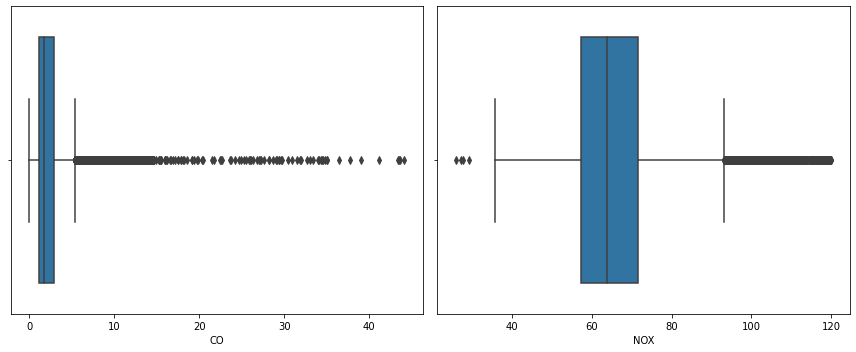

In [3]:
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1) 
sns.boxplot(Data.CO)
plt.subplot(1, 2, 2)
sns.boxplot(Data.NOX)
plt.tight_layout()  
plt.show()

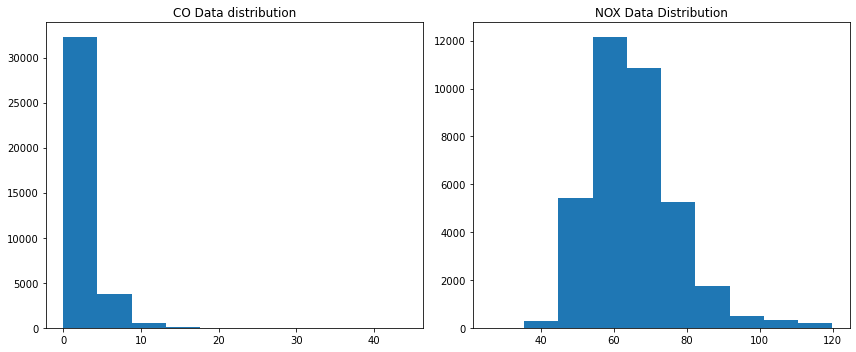

In [9]:
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1) 
plt.hist(Data.CO)
plt.title("CO Data distribution")
plt.subplot(1, 2, 2)
plt.hist(Data.NOX)
plt.title("NOX Data Distribution")
plt.tight_layout()  
plt.show()

So we see CO Data is heavy skewed towards left side where as NOx data is not skewed 
we use IQR anomaly detection and in NOx we use Z-Score

# Anomaly Detection in CO 

In [10]:
print("Skewed data = ",Data.CO.skew())
q3 = Data['CO'].quantile(0.97)
q1 = Data['CO'].quantile(0.09)
IQR = q3-q1
highest = q3+(1.5*IQR)
lowest = q1-(1.5*IQR)
print(highest,lowest)

Skewed data =  4.8381739410908615
17.861740400000006 -9.600010000000003


In [11]:
Data[(Data['CO']>=highest)|(Data['CO']<=lowest)].shape

(64, 11)

In [12]:
Data['CO_Contaminate'] = np.where(Data['CO']>=highest,1,0)
Data

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX,CO_Contaminate
0,4.5878,1018.7,83.675,3.5758,23.979,1086.2,549.83,134.67,11.898,0.32663,81.952,0
1,4.2932,1018.3,84.235,3.5709,23.951,1086.1,550.05,134.67,11.892,0.44784,82.377,0
2,3.9045,1018.4,84.858,3.5828,23.990,1086.5,550.19,135.10,12.042,0.45144,83.776,0
3,3.7436,1018.3,85.434,3.5808,23.911,1086.5,550.17,135.03,11.990,0.23107,82.505,0
4,3.7516,1017.8,85.182,3.5781,23.917,1085.9,550.00,134.67,11.910,0.26747,82.028,0
...,...,...,...,...,...,...,...,...,...,...,...,...
36728,3.6268,1028.5,93.200,3.1661,19.087,1037.0,541.59,109.08,10.411,10.99300,89.172,0
36729,4.1674,1028.6,94.036,3.1923,19.016,1037.6,542.28,108.79,10.344,11.14400,88.849,0
36730,5.4820,1028.5,95.219,3.3128,18.857,1038.0,543.48,107.81,10.462,11.41400,96.147,0
36731,5.8837,1028.7,94.200,3.9831,23.563,1076.9,550.11,131.41,11.771,3.31340,64.738,0


In [13]:
Data[Data['CO_Contaminate']==1]

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX,CO_Contaminate
2294,12.0500,1018.0,88.508,3.1776,21.273,1059.9,543.48,119.30,11.016,18.493,67.162,1
3108,19.2820,1013.1,91.558,3.8430,25.552,1072.9,537.66,131.02,12.138,21.748,85.353,1
5776,24.6500,1006.5,76.608,4.0148,25.649,1091.1,550.10,133.77,12.156,32.676,47.439,1
6293,11.5850,1018.2,92.751,3.2518,18.784,1009.5,519.71,100.83,10.253,39.050,111.780,1
6451,11.5500,1024.1,75.234,3.8511,23.984,1086.5,549.41,134.78,11.956,30.866,64.374,1
...,...,...,...,...,...,...,...,...,...,...,...,...
30933,11.2570,1007.6,84.412,2.7025,19.879,1018.8,533.36,102.79,10.185,41.097,75.444,1
33326,30.2170,1010.8,39.650,4.4695,30.633,1099.9,542.97,149.90,13.341,31.869,88.947,1
34110,28.0350,1015.1,47.921,3.9139,25.423,1084.0,549.85,131.19,12.055,36.454,102.330,1
35100,18.1570,1013.9,66.946,3.8191,24.346,1079.1,550.32,130.96,11.847,19.139,35.598,1


# Anomaly Detection in NOX

In [15]:
print("skewness of Nox = ",Data['NOX'].skew())
NOX = Data['NOX']
high = NOX.mean()+3*NOX.std()
low = NOX.mean()-3*NOX.std()
print(high,low)

skewness of Nox =  1.0267788505165132
100.32813907552213 30.257995462903814


In [16]:
Data[(Data['NOX']>=high)|(Data['NOX']<=low)]

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX,CO_Contaminate
453,14.7170,1009.9,88.342,3.9776,24.268,1086.4,549.84,133.67,11.808,0.96789,102.30,0
1668,9.3772,1021.9,71.852,3.7515,20.452,1050.3,540.83,115.79,10.777,6.89310,100.34,0
2086,12.0660,1007.9,78.495,3.5795,18.803,1028.2,533.50,105.48,10.260,11.04400,112.56,0
2087,11.5430,1007.3,79.413,3.6172,18.892,1028.7,533.40,105.76,10.306,11.43200,113.24,0
2122,19.3310,1003.4,66.236,3.9189,19.329,1031.5,534.10,104.31,10.305,2.96490,116.04,0
...,...,...,...,...,...,...,...,...,...,...,...,...
35693,11.5860,1022.7,79.028,2.5930,18.297,1023.4,536.81,101.47,10.140,14.33900,112.61,0
35767,12.3720,1021.2,82.608,2.6259,18.260,1023.9,537.28,101.53,10.216,14.33500,103.99,0
36208,5.8072,1018.7,82.476,2.7448,19.025,1016.0,528.93,104.04,10.383,14.47100,115.35,0
36352,3.2831,1031.1,89.770,2.9365,18.808,1045.9,548.46,108.76,10.397,8.88490,106.30,0


In [17]:
Data['NOX_Contaminate'] = np.where(Data['NOX']>=high,1,0)

In [18]:
Data

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX,CO_Contaminate,NOX_Contaminate
0,4.5878,1018.7,83.675,3.5758,23.979,1086.2,549.83,134.67,11.898,0.32663,81.952,0,0
1,4.2932,1018.3,84.235,3.5709,23.951,1086.1,550.05,134.67,11.892,0.44784,82.377,0,0
2,3.9045,1018.4,84.858,3.5828,23.990,1086.5,550.19,135.10,12.042,0.45144,83.776,0,0
3,3.7436,1018.3,85.434,3.5808,23.911,1086.5,550.17,135.03,11.990,0.23107,82.505,0,0
4,3.7516,1017.8,85.182,3.5781,23.917,1085.9,550.00,134.67,11.910,0.26747,82.028,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
36728,3.6268,1028.5,93.200,3.1661,19.087,1037.0,541.59,109.08,10.411,10.99300,89.172,0,0
36729,4.1674,1028.6,94.036,3.1923,19.016,1037.6,542.28,108.79,10.344,11.14400,88.849,0,0
36730,5.4820,1028.5,95.219,3.3128,18.857,1038.0,543.48,107.81,10.462,11.41400,96.147,0,0
36731,5.8837,1028.7,94.200,3.9831,23.563,1076.9,550.11,131.41,11.771,3.31340,64.738,0,0


In [20]:
Data[Data['NOX_Contaminate']==1]

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX,CO_Contaminate,NOX_Contaminate
453,14.7170,1009.9,88.342,3.9776,24.268,1086.4,549.84,133.67,11.808,0.96789,102.30,0,1
1668,9.3772,1021.9,71.852,3.7515,20.452,1050.3,540.83,115.79,10.777,6.89310,100.34,0,1
2086,12.0660,1007.9,78.495,3.5795,18.803,1028.2,533.50,105.48,10.260,11.04400,112.56,0,1
2087,11.5430,1007.3,79.413,3.6172,18.892,1028.7,533.40,105.76,10.306,11.43200,113.24,0,1
2122,19.3310,1003.4,66.236,3.9189,19.329,1031.5,534.10,104.31,10.305,2.96490,116.04,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
35693,11.5860,1022.7,79.028,2.5930,18.297,1023.4,536.81,101.47,10.140,14.33900,112.61,0,1
35767,12.3720,1021.2,82.608,2.6259,18.260,1023.9,537.28,101.53,10.216,14.33500,103.99,0,1
36208,5.8072,1018.7,82.476,2.7448,19.025,1016.0,528.93,104.04,10.383,14.47100,115.35,0,1
36352,3.2831,1031.1,89.770,2.9365,18.808,1045.9,548.46,108.76,10.397,8.88490,106.30,0,1


In [21]:
Data

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX,CO_Contaminate,NOX_Contaminate
0,4.5878,1018.7,83.675,3.5758,23.979,1086.2,549.83,134.67,11.898,0.32663,81.952,0,0
1,4.2932,1018.3,84.235,3.5709,23.951,1086.1,550.05,134.67,11.892,0.44784,82.377,0,0
2,3.9045,1018.4,84.858,3.5828,23.990,1086.5,550.19,135.10,12.042,0.45144,83.776,0,0
3,3.7436,1018.3,85.434,3.5808,23.911,1086.5,550.17,135.03,11.990,0.23107,82.505,0,0
4,3.7516,1017.8,85.182,3.5781,23.917,1085.9,550.00,134.67,11.910,0.26747,82.028,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
36728,3.6268,1028.5,93.200,3.1661,19.087,1037.0,541.59,109.08,10.411,10.99300,89.172,0,0
36729,4.1674,1028.6,94.036,3.1923,19.016,1037.6,542.28,108.79,10.344,11.14400,88.849,0,0
36730,5.4820,1028.5,95.219,3.3128,18.857,1038.0,543.48,107.81,10.462,11.41400,96.147,0,0
36731,5.8837,1028.7,94.200,3.9831,23.563,1076.9,550.11,131.41,11.771,3.31340,64.738,0,0


In [22]:
Data.to_csv('datasets/contaminate_class.csv',index=False)

# Loading data 

In [2]:
cont = pd.read_csv('datasets/contaminate_class.csv')
cont

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX,CO_Contaminate,NOX_Contaminate
0,4.5878,1018.7,83.675,3.5758,23.979,1086.2,549.83,134.67,11.898,0.32663,81.952,0,0
1,4.2932,1018.3,84.235,3.5709,23.951,1086.1,550.05,134.67,11.892,0.44784,82.377,0,0
2,3.9045,1018.4,84.858,3.5828,23.990,1086.5,550.19,135.10,12.042,0.45144,83.776,0,0
3,3.7436,1018.3,85.434,3.5808,23.911,1086.5,550.17,135.03,11.990,0.23107,82.505,0,0
4,3.7516,1017.8,85.182,3.5781,23.917,1085.9,550.00,134.67,11.910,0.26747,82.028,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
36728,3.6268,1028.5,93.200,3.1661,19.087,1037.0,541.59,109.08,10.411,10.99300,89.172,0,0
36729,4.1674,1028.6,94.036,3.1923,19.016,1037.6,542.28,108.79,10.344,11.14400,88.849,0,0
36730,5.4820,1028.5,95.219,3.3128,18.857,1038.0,543.48,107.81,10.462,11.41400,96.147,0,0
36731,5.8837,1028.7,94.200,3.9831,23.563,1076.9,550.11,131.41,11.771,3.31340,64.738,0,0


In [24]:
cont.CO_Contaminate.value_counts()

CO_Contaminate
0    36669
1       64
Name: count, dtype: int64

In [25]:
cont.NOX_Contaminate.value_counts()

NOX_Contaminate
0    36191
1      542
Name: count, dtype: int64

# Balancing CO Data and Make classify Model 

In [26]:
cont.columns

Index(['AT', 'AP', 'AH', 'AFDP', 'GTEP', 'TIT', 'TAT', 'TEY', 'CDP', 'CO',
       'NOX', 'CO_Contaminate', 'NOX_Contaminate'],
      dtype='object')

In [27]:
carbon = cont[['AT','AP','AH','AFDP','GTEP','TIT','TAT','TEY','CDP','CO','NOX','CO_Contaminate']]
carbon 

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX,CO_Contaminate
0,4.5878,1018.7,83.675,3.5758,23.979,1086.2,549.83,134.67,11.898,0.32663,81.952,0
1,4.2932,1018.3,84.235,3.5709,23.951,1086.1,550.05,134.67,11.892,0.44784,82.377,0
2,3.9045,1018.4,84.858,3.5828,23.990,1086.5,550.19,135.10,12.042,0.45144,83.776,0
3,3.7436,1018.3,85.434,3.5808,23.911,1086.5,550.17,135.03,11.990,0.23107,82.505,0
4,3.7516,1017.8,85.182,3.5781,23.917,1085.9,550.00,134.67,11.910,0.26747,82.028,0
...,...,...,...,...,...,...,...,...,...,...,...,...
36728,3.6268,1028.5,93.200,3.1661,19.087,1037.0,541.59,109.08,10.411,10.99300,89.172,0
36729,4.1674,1028.6,94.036,3.1923,19.016,1037.6,542.28,108.79,10.344,11.14400,88.849,0
36730,5.4820,1028.5,95.219,3.3128,18.857,1038.0,543.48,107.81,10.462,11.41400,96.147,0
36731,5.8837,1028.7,94.200,3.9831,23.563,1076.9,550.11,131.41,11.771,3.31340,64.738,0


In [32]:
#balancing 
carbon1 = carbon[carbon['CO_Contaminate']==1]
print(carbon1.shape)
carbon0 = carbon[carbon['CO_Contaminate']==0]
print(carbon0.shape)

carbon00 = carbon0.sample(carbon1.shape[0])
print(carbon00.shape)

(64, 12)
(36669, 12)
(64, 12)


In [35]:
bcarbon = pd.concat([carbon1,carbon00])
bcarbon.shape

(128, 12)

In [36]:
bcarbon.sample(10)

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX,CO_Contaminate
2016,13.4040,1011.8,84.354,4.3409,23.396,1082.1,550.04,130.65,11.735,0.90084,77.767,0
28103,17.4150,1017.8,82.795,3.7666,20.344,1023.8,530.13,106.18,10.680,21.53800,84.898,1
7673,5.0232,1017.8,87.114,3.8648,21.435,1032.5,524.71,113.60,11.029,43.39700,92.062,1
6472,9.4097,1027.9,82.224,3.3003,18.987,1001.4,512.60,100.32,10.495,23.62900,107.890,1
5779,23.4230,1007.7,83.235,4.0447,25.717,1092.5,550.06,135.04,12.252,2.48570,65.393,0
14025,16.5080,1021.9,81.878,4.3576,24.751,1089.6,550.23,134.94,12.038,1.01610,62.850,0
36249,7.5422,1024.7,63.817,3.8899,28.916,1088.1,538.76,149.52,13.075,19.14100,82.105,1
3490,20.9020,1013.1,92.498,3.7735,24.864,1088.9,550.12,133.42,12.060,0.55411,59.251,0
30357,11.5740,1024.4,48.852,3.0075,22.900,1040.6,533.85,117.17,11.132,29.08400,81.604,1
23460,13.4860,1007.5,83.928,2.9630,20.104,1017.2,530.03,104.33,10.362,26.75200,77.282,1


In [37]:
bcarbon.CO_Contaminate.value_counts()

CO_Contaminate
1    64
0    64
Name: count, dtype: int64

In [40]:
x = bcarbon.iloc[:,0:11]
y = bcarbon.iloc[:,-1:]

In [46]:
xtrainc,xtestc,ytrainc,ytestc = train_test_split(x,y,test_size=0.2)
print(xtrainc.columns)
print(xtestc.columns)
print(ytrainc.columns)
print(ytestc.columns)
print("\n")
print(xtrainc.shape)
print(xtestc.shape)
print(ytrainc.shape)
print(ytestc.shape)

Index(['AT', 'AP', 'AH', 'AFDP', 'GTEP', 'TIT', 'TAT', 'TEY', 'CDP', 'CO',
       'NOX'],
      dtype='object')
Index(['AT', 'AP', 'AH', 'AFDP', 'GTEP', 'TIT', 'TAT', 'TEY', 'CDP', 'CO',
       'NOX'],
      dtype='object')
Index(['CO_Contaminate'], dtype='object')
Index(['CO_Contaminate'], dtype='object')


(102, 11)
(26, 11)
(102, 1)
(26, 1)


Accuracy score =  1.0


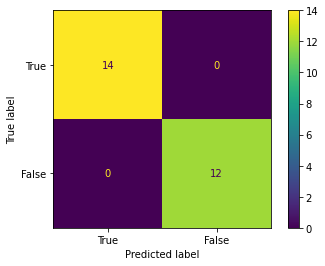

In [48]:
lr = LogisticRegression()
lr.fit(xtrainc,ytrainc)
pred1 = lr.predict(xtestc)
print("Accuracy score = ",accuracy_score(ytestc,pred1))
lrcm = confusion_matrix(ytestc,pred1)
ConfusionMatrixDisplay(lrcm,display_labels=[True,False]).plot()
plt.show()

Accuracy score =  1.0


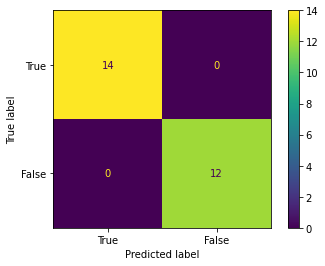

In [50]:
dtc = DecisionTreeClassifier()
dtc.fit(xtrainc,ytrainc)
pred2 = dtc.predict(xtestc)
print("Accuracy score = ",accuracy_score(ytestc,pred2))
dtccm = confusion_matrix(ytestc,pred2)
ConfusionMatrixDisplay(dtccm,display_labels=[True,False]).plot()
plt.show()

Accuracy score =  0.9615384615384616


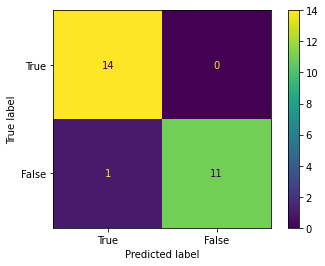

In [53]:
knc = KNeighborsClassifier()
knc.fit(xtrainc,ytrainc)
pred3 = knc.predict(xtestc)
print("Accuracy score = ",accuracy_score(ytestc,pred3))
knccm = confusion_matrix(ytestc,pred3)
ConfusionMatrixDisplay(knccm,display_labels=[True,False]).plot()
plt.show()

In [58]:
lr = LogisticRegression()
dtc = DecisionTreeClassifier()
knc = KNeighborsClassifier()

models = [('Linear Regression',lr),('DecisionTreeClassifier',dtc),('KNeighbourClassif',knc)]

In [59]:
for model in models:
    score = cross_val_score(model[1],xtrainc,ytrainc,cv=10,scoring='accuracy')
    print(model[0],np.round(np.mean(score)))

Linear Regression 1.0
DecisionTreeClassifier 1.0
KNeighbourClassif 1.0


Accuracy Score =  1.0


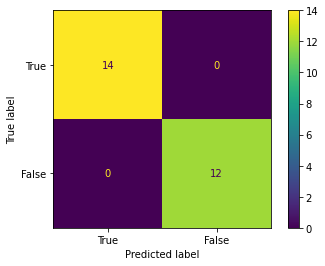

In [63]:
vr1 = VotingClassifier(estimators=models)
vr1.fit(xtrainc,ytrainc)
pred4 = vr1.predict(xtestc)
print("Accuracy Score = ",accuracy_score(ytestc,pred4))
vrcm1 = confusion_matrix(ytestc,pred4)
ConfusionMatrixDisplay(vrcm1,display_labels=[True,False]).plot()
plt.show()

In [64]:
vr1

VotingClassifier(estimators=[('Linear Regression', LogisticRegression()),
                             ('DecisionTreeClassifier',
                              DecisionTreeClassifier()),
                             ('KNeighbourClassif', KNeighborsClassifier())])

# Balancing NOX and making model

In [66]:
cont.columns

Index(['AT', 'AP', 'AH', 'AFDP', 'GTEP', 'TIT', 'TAT', 'TEY', 'CDP', 'CO',
       'NOX', 'CO_Contaminate', 'NOX_Contaminate'],
      dtype='object')

In [67]:
nitrogen = cont[['AT','AP','AH','AFDP','GTEP','TIT','TAT','TEY','CDP','CO','NOX','NOX_Contaminate']]
nitrogen

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX,NOX_Contaminate
0,4.5878,1018.7,83.675,3.5758,23.979,1086.2,549.83,134.67,11.898,0.32663,81.952,0
1,4.2932,1018.3,84.235,3.5709,23.951,1086.1,550.05,134.67,11.892,0.44784,82.377,0
2,3.9045,1018.4,84.858,3.5828,23.990,1086.5,550.19,135.10,12.042,0.45144,83.776,0
3,3.7436,1018.3,85.434,3.5808,23.911,1086.5,550.17,135.03,11.990,0.23107,82.505,0
4,3.7516,1017.8,85.182,3.5781,23.917,1085.9,550.00,134.67,11.910,0.26747,82.028,0
...,...,...,...,...,...,...,...,...,...,...,...,...
36728,3.6268,1028.5,93.200,3.1661,19.087,1037.0,541.59,109.08,10.411,10.99300,89.172,0
36729,4.1674,1028.6,94.036,3.1923,19.016,1037.6,542.28,108.79,10.344,11.14400,88.849,0
36730,5.4820,1028.5,95.219,3.3128,18.857,1038.0,543.48,107.81,10.462,11.41400,96.147,0
36731,5.8837,1028.7,94.200,3.9831,23.563,1076.9,550.11,131.41,11.771,3.31340,64.738,0


In [68]:
nitrogen.NOX_Contaminate.value_counts()

NOX_Contaminate
0    36191
1      542
Name: count, dtype: int64

In [69]:
#balancing 
nitrogen1 = nitrogen[nitrogen['NOX_Contaminate']==1]
print(nitrogen1.shape)
nitrogen0 = nitrogen[nitrogen['NOX_Contaminate']==0]
print(nitrogen0.shape)

nitrogen00 = nitrogen0.sample(nitrogen1.shape[0])
print(nitrogen00.shape)

(542, 12)
(36191, 12)
(542, 12)


In [71]:
bnitrogen = pd.concat([nitrogen1,nitrogen00])
bnitrogen.shape

(1084, 12)

In [72]:
bnitrogen.sample(12)

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX,NOX_Contaminate
17833,15.7870,1011.9,86.331,2.6953,18.451,1038.7,542.33,103.38,10.021,12.11300,104.040,1
16546,12.0090,1009.6,98.390,2.6076,18.988,1048.6,547.51,108.10,10.368,9.46900,101.890,1
6200,14.7160,1022.4,74.598,3.1306,18.756,1026.4,531.47,103.80,10.320,13.40100,111.890,1
12920,21.3390,1013.6,94.108,4.4947,25.283,1090.0,550.14,133.69,11.895,2.42660,63.727,0
22960,11.5180,1014.0,92.052,3.5316,25.115,1077.1,549.91,133.76,11.891,1.31780,62.912,0
6293,11.5850,1018.2,92.751,3.2518,18.784,1009.5,519.71,100.83,10.253,39.05000,111.780,1
2592,17.3150,1017.3,62.962,4.5568,32.452,1099.7,530.03,159.52,13.969,1.83560,62.521,0
20820,20.7920,1021.1,77.914,3.6442,28.333,1100.0,546.34,143.53,12.846,0.66015,101.690,1
15247,7.6518,1016.1,56.189,4.1364,33.268,1100.0,526.91,164.23,14.119,0.63183,71.883,0
15115,5.0937,1021.1,94.350,2.7639,21.584,1067.6,547.87,121.67,11.183,5.43610,112.080,1


In [74]:
bnitrogen.NOX_Contaminate.value_counts()

NOX_Contaminate
1    542
0    542
Name: count, dtype: int64

In [77]:
x1 = bnitrogen.iloc[:,0:11]
y1 = bnitrogen.iloc[:,-1:]

print(x1.shape)
print(y1.shape)
print("\n")
print(x1.columns)
print(y1.columns)

(1084, 11)
(1084, 1)


Index(['AT', 'AP', 'AH', 'AFDP', 'GTEP', 'TIT', 'TAT', 'TEY', 'CDP', 'CO',
       'NOX'],
      dtype='object')
Index(['NOX_Contaminate'], dtype='object')


In [85]:
xtrainn,xtestn,ytrainn,ytestn = train_test_split(x1,y1,test_size=0.2)
print(xtrainn.shape)
print(xtrainn.columns)
print(ytrainn.shape)
print(ytrainn.columns)

print(xtestn.shape)
print(xtestn.columns)
print(ytestn.shape)
print(ytestn.columns)

(867, 11)
Index(['AT', 'AP', 'AH', 'AFDP', 'GTEP', 'TIT', 'TAT', 'TEY', 'CDP', 'CO',
       'NOX'],
      dtype='object')
(867, 1)
Index(['NOX_Contaminate'], dtype='object')
(217, 11)
Index(['AT', 'AP', 'AH', 'AFDP', 'GTEP', 'TIT', 'TAT', 'TEY', 'CDP', 'CO',
       'NOX'],
      dtype='object')
(217, 1)
Index(['NOX_Contaminate'], dtype='object')


In [87]:
lr = LogisticRegression()
dtc = DecisionTreeClassifier()
knc = KNeighborsClassifier()

modelns = [('Linear Regression',lr),('DecisionTreeClassifier',dtc),('KNeighbourClassif',knc)]


In [88]:
for modeln in modelns:
    scoren = cross_val_score(modeln[1],xtrainn,ytrainn,cv=12,scoring='accuracy')
    print(modeln[0],np.round(np.mean(scoren),3))

Linear Regression 0.997
DecisionTreeClassifier 1.0
KNeighbourClassif 0.991


Accuracy Score =  1.0


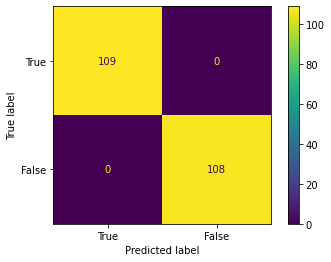

In [90]:
vr2 = VotingClassifier(estimators=modelns)
vr2.fit(xtrainn,ytrainn)
pred5 = vr2.predict(xtestn)
print("Accuracy Score = ",accuracy_score(ytestn,pred5))
vrcm2 = confusion_matrix(ytestn,pred5)
ConfusionMatrixDisplay(vrcm2,display_labels=[True,False]).plot()
plt.show()

In [91]:
vr2

VotingClassifier(estimators=[('Linear Regression', LogisticRegression()),
                             ('DecisionTreeClassifier',
                              DecisionTreeClassifier()),
                             ('KNeighbourClassif', KNeighborsClassifier())])

# Testing Our model

In [92]:
gas = pd.read_csv('datasets/gt_full.csv')
gas

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
0,4.5878,1018.7,83.675,3.5758,23.979,1086.2,549.83,134.67,11.898,0.32663,81.952
1,4.2932,1018.3,84.235,3.5709,23.951,1086.1,550.05,134.67,11.892,0.44784,82.377
2,3.9045,1018.4,84.858,3.5828,23.990,1086.5,550.19,135.10,12.042,0.45144,83.776
3,3.7436,1018.3,85.434,3.5808,23.911,1086.5,550.17,135.03,11.990,0.23107,82.505
4,3.7516,1017.8,85.182,3.5781,23.917,1085.9,550.00,134.67,11.910,0.26747,82.028
...,...,...,...,...,...,...,...,...,...,...,...
36728,3.6268,1028.5,93.200,3.1661,19.087,1037.0,541.59,109.08,10.411,10.99300,89.172
36729,4.1674,1028.6,94.036,3.1923,19.016,1037.6,542.28,108.79,10.344,11.14400,88.849
36730,5.4820,1028.5,95.219,3.3128,18.857,1038.0,543.48,107.81,10.462,11.41400,96.147
36731,5.8837,1028.7,94.200,3.9831,23.563,1076.9,550.11,131.41,11.771,3.31340,64.738


In [101]:
pp = gas.sample(1)
pp = pp.values
n = np.array(pp)
print(n)
predc = vr1.predict(n)
predn = vr2.predict(n)
print(predc)
print(predn)

[[  15.198  1017.3      84.002     2.6268   22.868  1061.9     549.77
   119.91     10.989     2.477    67.6   ]]
[0]
[0]


In [104]:
for i in range(0,1236):
    pp = gas.sample(1)
    pp = pp.values
    n = np.array(pp)
    print(n)
    predc = vr1.predict(n)
    predn = vr2.predict(n)
    print("=============================\n")
    print(predc[0])
    print(predn[0])
    print("\n=============================\n")

[[  23.887  1016.2      43.051     3.3787   29.659  1078.5     549.85
   129.66     11.832     2.4277   61.479 ]]

0
0


[[  17.347  1015.2      93.788     3.6976   19.237  1054.3     550.08
   108.58     10.455     5.737    60.642 ]]

0
0


[[  10.124  1013.9      62.699     3.1683   24.969  1075.3     550.01
   130.98     11.641     3.9504   69.479 ]]

0
0


[[   6.6795 1015.2      83.526     4.0072   33.753  1099.9     535.97
   161.01     13.881     2.4544   60.178 ]]

0
0


[[  26.358  1007.       56.274     4.6528   29.88   1100.1     545.24
   148.83     13.203     1.5579   49.56  ]]

0
0


[[2.4551e+01 1.0109e+03 8.3416e+01 3.8594e+00 2.5588e+01 1.0914e+03
  5.5030e+02 1.3394e+02 1.2217e+01 2.7784e-01 5.8265e+01]]

0
0


[[  21.368  1002.6      69.955     4.1608   20.296  1058.4     549.79
   111.44     10.554     2.301    64.749 ]]

0
0


[[   9.9935 1013.6      91.489     2.9073   21.182  1062.5     546.87
   119.52     10.955     6.0097   85.882 ]]

0
0


[[  20.809  1015.5 


0
0


[[  14.426  1013.4      79.921     4.128    24.599  1086.7     550.02
   133.8      11.959     1.9049   72.63  ]]

0
0


[[  27.587  1011.1      80.946     4.1348   25.981  1092.6     549.6
   133.82     12.204     1.7448   59.762 ]]

0
0


[[  12.553  1006.5      74.105     2.9362   24.236  1067.5     549.93
   125.37     11.341     1.9767   66.227 ]]

0
0


[[2.3963e+01 1.0064e+03 8.6742e+01 4.2847e+00 2.6018e+01 1.0926e+03
  5.5017e+02 1.3518e+02 1.2144e+01 7.0088e-01 6.1579e+01]]

0
0


[[  14.547  1018.1      67.353     3.2243   23.209  1074.1     549.81
   128.62     11.57      2.5062   55.203 ]]

0
0


[[  23.195  1009.4      93.706     5.0094   29.464  1099.9     547.7
   145.42     13.022     1.4374   54.297 ]]

0
0


[[  17.959  1005.5      91.306     3.9684   25.561  1082.2     550.42
   135.4      11.999     1.2825   63.945 ]]

0
0


[[   7.9497 1020.6      79.012     3.1505   24.304  1085.4     549.94
   134.92     11.841     1.1086   68.928 ]]

0
0


[[  25.673  10

[[   7.3063 1015.6      85.802     2.3188   18.616  1039.6     546.04
   108.75     10.246     6.4182   84.073 ]]

0
0


[[  22.167  1014.8      68.941     4.1635   25.432  1090.8     550.2
   134.04     12.199     2.0174   67.802 ]]

0
0


[[2.7242e+01 1.0112e+03 5.8016e+01 4.1058e+00 2.5892e+01 1.0930e+03
  5.5006e+02 1.3379e+02 1.2231e+01 1.0385e+00 6.1775e+01]]

0
0


[[  27.023  1010.8      61.267     4.0755   25.508  1091.4     550.31
   133.12     12.119     1.8088   66.347 ]]

0
0


[[  25.936  1008.9      76.313     4.2322   29.266  1099.8     547.18
   145.9      13.087     2.019    57.381 ]]

0
0


[[  14.236  1016.9      95.489     4.3904   24.638  1087.7     549.9
   134.71     12.048     1.5186   73.44  ]]

0
0


[[   9.6926  999.18     99.601     2.7616   23.733  1082.5     549.79
   133.37     11.734     2.1368   74.974 ]]

0
0


[[   8.0869 1004.2      94.723     4.2325   21.735  1065.9     547.99
   122.75     11.073     2.174    77.974 ]]

0
0


[[  20.363  1016.3   

   126.66     11.563     1.1997   62.569 ]]

0
0


[[  16.715  1013.4      91.75      3.5759   19.194  1054.9     549.93
   109.4      10.37      5.8127   64.118 ]]

0
0


[[  14.63   1016.1      88.059     3.9965   21.98   1072.2     549.79
   123.11     11.138     2.3943   73.802 ]]

0
0


[[  19.763  1012.1      87.126     3.1753   19.51   1048.8     550.28
   109.07     10.345     4.6754   47.763 ]]

0
0


[[  14.202   993.73     92.621     2.6297   19.115  1051.6     550.
   108.33     10.266     5.9928   75.979 ]]

0
0


[[  10.626  1022.8      94.318     4.444    24.281  1087.1     549.84
   134.68     11.932     1.1276   76.219 ]]

0
0


[[  11.348  1012.8      89.567     2.8913   18.562  1030.      540.61
   103.6      10.182     6.882    89.054 ]]

0
0


[[  18.009  1022.4      75.793     3.5804   23.172  1072.6     550.14
   126.07     11.552     2.0757   49.539 ]]

0
0


[[  18.055  1013.3      75.178     3.7293   25.568  1079.3     550.08
   133.22     12.068     1.184    

0


[[  20.68   1014.3      96.68      5.1922   30.226  1100.2     545.18
   148.06     13.188     1.2188   56.157 ]]

0
0


[[  14.218  1012.9      82.723     4.2617   24.645  1088.      549.99
   134.82     12.019     1.1363   66.975 ]]

0
0


[[   7.0928 1007.5      97.755     3.1031   23.815  1083.5     550.17
   134.27     11.839     1.3605   73.301 ]]

0
0


[[   7.6562 1011.7      81.128     2.6518   20.448  1052.4     548.57
   116.61     10.722     5.8825   78.098 ]]

0
0


[[1.8650e+01 1.0069e+03 8.7326e+01 3.7211e+00 2.4898e+01 1.0876e+03
  5.5017e+02 1.3369e+02 1.1906e+01 7.2543e-01 6.4130e+01]]

0
0


[[1.0307e+01 1.0241e+03 9.1224e+01 5.5249e+00 3.2061e+01 1.1000e+03
  5.3096e+02 1.5764e+02 1.3924e+01 9.7810e-01 6.0380e+01]]

0
0


[[   9.0341 1020.4      93.961     3.3746   25.153  1078.2     550.1
   135.47     11.99      1.3098   67.024 ]]

0
0


[[  13.866  1018.8      86.488     2.5494   19.117  1052.4     549.03
   109.09     10.405     7.6912   86.233 ]]

0
0


[[ 


0
0


[[  20.2    1017.6      92.033     5.3021   25.143  1089.      550.12
   132.96     11.903     1.3942   64.521 ]]

0
0


[[1.1331e+01 1.0160e+03 9.4971e+01 3.1497e+00 2.4660e+01 1.0859e+03
  5.4992e+02 1.3428e+02 1.1909e+01 8.9696e-01 6.6693e+01]]

0
0


[[   9.7124 1025.8      83.052     4.7151   24.06   1083.9     549.34
   133.78     11.887     1.387    81.863 ]]

0
0


[[  11.255  1007.1      99.22      3.6952   19.119  1054.6     549.81
   111.73     10.428     3.2939   76.34  ]]

0
0


[[  18.805  1014.5      81.487     4.3912   31.183  1099.9     540.16
   153.26     13.531     1.4816   47.868 ]]

0
0


[[9.3979e+00 1.0059e+03 9.4609e+01 4.2865e+00 3.2989e+01 1.1001e+03
  5.2872e+02 1.6218e+02 1.3994e+01 1.0670e+00 7.0114e+01]]

0
0


[[  17.839  1012.1      96.641     3.8347   24.113  1075.3     550.
   128.82     11.733     1.5665   50.627 ]]

0
0


[[  29.073  1008.3      64.511     4.719    29.741  1099.5     541.25
   146.31     13.081     1.6463   59.024 ]]

0
0


[

[[  26.729  1013.4      30.211     3.8733   35.315  1098.6     549.88
   141.59     12.817     1.1394   67.466 ]]

0
0


[[  12.594  1016.7      86.445     3.7056   25.66   1088.      545.52
   139.39     12.227     1.1162   65.179 ]]

0
0


[[  26.564  1011.5      60.505     3.5392   20.057  1058.3     550.01
   108.63     10.542     3.8209   54.406 ]]

0
0


[[  14.95   1016.9      71.036     4.2495   31.656  1099.9     537.01
   156.44     13.738     1.7512   50.162 ]]

0
0


[[  19.363  1014.1      89.382     4.0942   32.07   1099.9     534.69
   153.17     13.576     1.5406   71.873 ]]

0
0


[[  23.058  1010.5      92.367     3.9668   24.852  1077.8     550.05
   128.61     11.859     1.7834   48.448 ]]

0
0


[[  11.42   1012.       89.855     2.5071   21.508  1053.2     548.69
   115.29     10.758     3.0811   72.459 ]]

0
0


[[  11.841  1016.9      70.533     3.4396   28.768  1099.4     547.19
   150.97     13.022     2.8056   66.375 ]]

0
0


[[  26.703  1009.4      72.87   


0
0


[[  23.575  1006.       79.354     4.0251   25.272  1088.6     550.24
   132.9      12.011     1.631    62.369 ]]

0
0


[[  13.175  1015.9      77.627     2.7312   19.248  1048.8     549.59
   110.79     10.439     5.0881   61.337 ]]

0
0


[[1.1795e+01 1.0216e+03 6.4587e+01 5.0601e+00 3.2265e+01 1.0999e+03
  5.2909e+02 1.6074e+02 1.4112e+01 5.9049e-02 6.6748e+01]]

0
0


[[  21.906  1010.4      89.89      4.3513   25.459  1090.8     549.73
   134.5      12.185     1.8395   63.073 ]]

0
0


[[  22.776  1011.6      79.065     5.2263   25.643  1090.6     549.94
   133.74     12.195     3.6737   73.751 ]]

0
0


[[3.7561e-02 1.0114e+03 7.5725e+01 3.0102e+00 2.3110e+01 1.0733e+03
  5.5000e+02 1.3019e+02 1.1521e+01 3.2779e+00 8.5410e+01]]

0
0


[[  30.52   1010.6      47.107     4.3232   30.596  1099.9     543.33
   149.26     13.285     1.3844   52.044 ]]

0
0


[[  23.066  1009.8      90.548     4.742    27.835  1084.9     544.3
   136.87     12.528     1.9944   53.614 ]]

0
0





0
0


[[  25.743  1009.8      82.584     4.2649   26.084  1092.5     550.32
   134.8      12.21      1.5311   60.069 ]]

0
0


[[   8.2788 1028.9      84.05      4.13     23.567  1085.5     549.98
   134.38     11.849     1.4793   82.138 ]]

0
0


[[  18.09   1007.1      93.045     3.8729   25.366  1081.1     550.04
   134.17     12.045     1.9622   60.056 ]]

0
0


[[   9.0246 1017.3      68.821     3.6225   28.735  1093.5     538.83
   149.38     12.999     1.5422   74.546 ]]

0
0


[[  24.737  1012.5      75.416     3.1327   20.727  1063.      549.95
   113.32     10.812     1.412    53.024 ]]

0
0


[[  12.278  1017.6      65.118     3.2198   23.352  1074.7     549.91
   129.76     11.655     2.8986   60.298 ]]

0
0


[[  28.501  1013.       56.157     4.0489   20.397  1060.1     550.07
   109.29     10.698     3.8066   55.38  ]]

0
0


[[3.0623e+01 1.0086e+03 3.9078e+01 4.2961e+00 2.6192e+01 1.0925e+03
  5.5002e+02 1.3281e+02 1.2264e+01 9.1941e-01 7.0085e+01]]

0
0


[[2.9106e+01

   150.       13.286     1.4808   53.711 ]]

0
0


[[   4.4075 1015.2      89.513     2.5649   19.352  1057.6     549.81
   112.77     10.622     6.1136  111.54  ]]

0
1


[[   8.0764 1021.       81.36      2.6153   22.877  1043.1     547.95
   108.82     10.343     8.056    79.186 ]]

0
0


[[  12.983  1018.3      66.381     4.0734   36.244  1100.      535.98
   157.46     13.836     2.9408   58.887 ]]

0
0


[[  15.4    1011.3      59.436     4.0848   33.096  1100.      539.45
   155.       13.579     1.7413   59.782 ]]

0
0


[[  22.114  1015.       89.367     3.0836   19.835  1059.4     550.04
   111.77     10.589     2.2964   54.14  ]]

0
0


[[   5.2746 1015.8      80.299     4.016    23.637  1083.9     549.88
   134.65     11.771     1.5187   83.877 ]]

0
0


[[  12.965  1005.5      94.275     4.1746   24.233  1085.5     550.16
   133.76     11.793     1.5824   73.276 ]]

0
0


[[  23.94   1011.8      50.329     2.9032   18.829  1052.      549.87
   105.81     10.244     2.4759 


0
0


[[  19.975  1011.8      74.421     3.0245   19.607  1050.6     550.32
   110.15     10.576     3.748    58.57  ]]

0
0


[[  23.078  1005.1      94.878     3.4227   20.591  1052.1     550.2
   110.18     10.563     4.6535   49.925 ]]

0
0


[[  17.276  1023.9      74.996     3.3106   19.416  1058.3     549.78
   111.69     10.701     3.2568   70.24  ]]

0
0


[[  25.477  1011.4      78.095     3.7997   24.931  1077.4     550.12
   126.94     11.789     2.0559   47.633 ]]

0
0


[[  14.75   1019.4      62.969     4.2283   33.767  1100.      536.27
   157.24     13.791     3.3591   57.367 ]]

0
0


[[  17.597  1019.4      95.76      3.2233   25.59   1090.      550.08
   135.02     11.997     1.3295   75.178 ]]

0
0


[[  15.591  1012.2     100.11      2.2821   19.114  1053.6     549.95
   108.97     10.379     5.2492   68.315 ]]

0
0


[[  12.761  1007.7      97.836     3.7045   24.511  1073.7     549.76
   131.28     11.641     1.5019   59.864 ]]

0
0


[[1.6642e+01 1.0214e+03 6.

  5.4168e+02 1.5235e+02 1.3412e+01 7.7762e-01 5.1780e+01]]

0
0


[[  20.424  1012.4      89.753     3.5807   19.456  1055.2     549.83
   108.36     10.445     5.0446   57.206 ]]

0
0


[[  27.919  1011.1      46.135     4.0984   25.984  1093.2     549.96
   134.24     12.187     1.2098   68.072 ]]

0
0


[[  19.003  1010.1      76.277     3.7432   26.451  1078.8     543.87
   135.77     12.26      2.642    52.371 ]]

0
0


[[  27.849  1012.3      72.496     4.3339   26.305  1094.4     550.31
   134.8      12.299     2.8362   65.516 ]]

0
0


[[   9.178  1013.5      86.955     4.0557   24.075  1084.9     550.16
   134.74     11.853     1.3193   78.899 ]]

0
0


[[  13.191  1021.       99.473     3.6981   25.71   1080.3     550.01
   134.92     12.086     1.2487   59.858 ]]

0
0


[[2.7899e+01 1.0058e+03 5.0940e+01 4.1467e+00 2.6256e+01 1.0931e+03
  5.4987e+02 1.3484e+02 1.2131e+01 7.1187e-01 6.5323e+01]]

0
0


[[  21.269  1014.8      84.79      3.6562   20.006  1058.6     550.16
   1

   133.84     12.276     1.3309   56.622 ]]

0
0


[[  18.687  1011.3      94.164     3.6718   19.503  1054.9     549.9
   108.95     10.422     4.8454   56.811 ]]

0
0


[[3.8227e+00 1.0166e+03 8.4339e+01 5.3315e+00 3.3362e+01 1.1003e+03
  5.2476e+02 1.6832e+02 1.4342e+01 8.7034e-02 6.7089e+01]]

0
0


[[  10.929  1015.6      90.07      4.1081   32.715  1099.9     529.36
   160.4      13.952     1.2032   67.433 ]]

0
0


[[2.6309e+01 1.0094e+03 6.1145e+01 4.0623e+00 2.6162e+01 1.0935e+03
  5.4997e+02 1.3432e+02 1.2277e+01 5.6608e-02 6.4600e+01]]

0
0


[[   8.8575 1014.3      60.163     4.1073   32.3    1100.      531.44
   159.41     13.849     1.3403   77.219 ]]

0
0


[[  18.395  1009.2      80.664     3.1134   20.122  1051.1     550.38
   111.53     10.623     4.424    65.581 ]]

0
0


[[  14.814   998.6      62.806     3.3023   28.866  1076.6     549.94
   131.91     11.756     3.5465   64.267 ]]

0
0


[[1.1865e+01 1.0174e+03 7.6863e+01 4.3546e+00 3.2741e+01 1.1000e+03
  5.3020e

[[  24.671  1005.9      75.445     4.0688   25.609  1090.7     549.93
   133.86     12.038     6.2392   61.635 ]]

0
0


[[  17.76   1015.       92.172     3.503    19.273  1055.7     549.9
   109.76     10.324     6.1345   62.216 ]]

0
0


[[2.3405e+01 1.0128e+03 8.1908e+01 5.0979e+00 2.9905e+01 1.1000e+03
  5.4626e+02 1.4706e+02 1.3143e+01 7.1316e-01 5.4846e+01]]

0
0


[[3.7782e+00 1.0210e+03 8.1302e+01 3.8672e+00 2.3587e+01 1.0861e+03
  5.5033e+02 1.3466e+02 1.1859e+01 8.2379e-01 8.4898e+01]]

0
0


[[  26.335  1011.8      91.841     4.0129   23.413  1069.6     550.07
   120.9      11.446     2.3462   45.954 ]]

0
0


[[  23.256  1018.5      62.541     4.3041   25.367  1090.5     549.7
   132.79     12.132     1.5238   67.976 ]]

0
0


[[3.1278e+01 1.0068e+03 4.3587e+01 4.4070e+00 2.6507e+01 1.0948e+03
  5.5044e+02 1.3354e+02 1.2247e+01 1.0150e+00 6.6233e+01]]

0
0


[[  19.646  1018.2      87.269     5.2445   25.304  1090.4     549.93
   134.74     12.012     1.1822   68.593 ]]

0

0


[[  29.595 1014.6     44.917    4.438   30.783 1100.     542.35   149.76
    13.371   11.845   36.676]]

0
0


[[  23.281  1002.3      98.39      4.3032   23.816  1070.6     549.97
   123.1      11.459     2.1087   48.704 ]]

0
0


[[  28.769  1013.2      77.465     4.1499   24.144  1073.2     549.73
   122.42     11.531     1.22     45.478 ]]

0
0


[[8.9835e+00 1.0152e+03 8.3538e+01 4.1755e+00 3.2962e+01 1.1000e+03
  5.2835e+02 1.6169e+02 1.4072e+01 8.9940e-01 7.8867e+01]]

0
0


[[2.4684e+01 1.0138e+03 8.8171e+01 4.2901e+00 2.8654e+01 1.0993e+03
  5.4420e+02 1.4331e+02 1.2873e+01 3.8597e-01 5.7264e+01]]

0
0


[[  10.538  1004.1      77.892     2.5831   18.735  1039.      547.52
   106.74     10.187     6.9949   78.71  ]]

0
0


[[  28.115  1011.6      61.374     3.8716   25.495  1090.9     550.34
   132.31     12.174     1.4677   64.054 ]]

0
0


[[  21.274  1008.1      77.572     3.1017   19.975  1058.5     549.93
   111.64     10.644     1.6309   56.672 ]]

0
0


[[1.1516e+01


1
1


[[1.0351e+01 1.0134e+03 6.9262e+01 5.3029e+00 3.2024e+01 1.0999e+03
  5.3080e+02 1.5980e+02 1.3859e+01 8.4475e-01 7.0687e+01]]

0
0


[[  13.549  1011.7      78.343     2.6669   18.974  1047.      550.17
   109.2      10.391     5.3236   59.85  ]]

0
0


[[  24.542  1010.8      91.487     4.182    25.281  1079.8     550.02
   128.9      11.948     1.6632   49.558 ]]

0
0


[[  20.489  1003.7      68.491     4.9831   25.388  1087.9     550.26
   133.71     11.997     2.0926   73.877 ]]

0
0


[[   6.7551 1009.3      76.992     3.3444   24.377  1080.2     550.34
   136.14     11.988     3.9329   72.613 ]]

0
0


[[1.9234e+01 1.0068e+03 6.7314e+01 3.3907e+00 2.4130e+01 1.0712e+03
  5.5000e+02 1.2747e+02 1.1600e+01 2.6384e-01 5.7395e+01]]

0
0


[[4.7262e+00 1.0180e+03 9.6455e+01 3.5168e+00 2.4509e+01 1.0752e+03
  5.4974e+02 1.3246e+02 1.1829e+01 1.0569e+00 6.4883e+01]]

0
0


[[  17.928  1007.2      64.711     3.9538   31.082  1099.9     535.98
   153.45     13.476     1.428    73.


0
0


[[  22.625  1014.6      62.07      4.2796   20.785  1061.3     549.18
   113.52     10.724     4.5917   70.435 ]]

0
0


[[1.0506e+01 1.0174e+03 7.9433e+01 4.1917e+00 3.0205e+01 1.1003e+03
  5.3459e+02 1.5830e+02 1.3757e+01 7.7399e-01 6.4273e+01]]

0
0


[[  28.045  1012.1      75.484     5.1635   26.545  1093.8     549.2
   133.74     12.323     1.9684   58.281 ]]

0
0


[[  28.195  1009.       48.567     3.8781   26.405  1088.7     550.3
   136.09     12.372     2.4102   55.327 ]]

0
0


[[  22.116  1021.5      67.543     4.3397   23.862  1073.6     550.02
   124.87     11.577     1.9214   56.687 ]]

0
0


[[   8.4377 1017.6      85.144     2.5486   19.345  1056.6     549.77
   111.83     10.584     6.5257  101.57  ]]

0
1


[[8.7489e+00 1.0044e+03 9.3103e+01 4.8122e+00 2.5923e+01 1.0924e+03
  5.4946e+02 1.4158e+02 1.2276e+01 5.7248e-01 8.1372e+01]]

0
0


[[  31.171  1009.1      52.748     4.4      30.05   1100.1     545.32
   146.82     13.16      1.2545   56.569 ]]

0
0


[

[[2.8400e+01 1.0075e+03 5.9008e+01 4.6179e+00 3.0706e+01 1.0998e+03
  5.3831e+02 1.4801e+02 1.3318e+01 3.2843e-01 5.7725e+01]]

0
0


[[  14.917  1021.1      89.082     3.4208   21.674  1064.8     550.06
   121.19     11.215     3.1272   53.083 ]]

0
0


[[  23.232  1013.4      36.728     2.9543   20.931  1056.8     549.53
   113.74     10.814     3.3853   59.144 ]]

0
0


[[8.9323e+00 1.0294e+03 8.4612e+01 4.5057e+00 2.7478e+01 1.0996e+03
  5.4583e+02 1.4871e+02 1.2726e+01 4.0559e-01 7.7507e+01]]

0
0


[[6.2824e+00 1.0169e+03 9.1060e+01 3.8709e+00 2.3789e+01 1.0847e+03
  5.5004e+02 1.3436e+02 1.1855e+01 1.0581e+00 8.0275e+01]]

0
0


[[1.1775e+01 1.0163e+03 7.4537e+01 5.0901e+00 3.2753e+01 1.1000e+03
  5.2799e+02 1.6175e+02 1.4064e+01 7.6410e-01 6.7067e+01]]

0
0


[[  31.445  1011.5      59.417     4.4408   26.585  1094.4     549.85
   133.97     12.23      1.9667   69.128 ]]

0
0


[[4.0995e+00 1.0012e+03 9.2496e+01 3.3754e+00 2.4391e+01 1.0746e+03
  5.4996e+02 1.3360e+02 1.1788e+0

In [3]:
cont

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX,CO_Contaminate,NOX_Contaminate
0,4.5878,1018.7,83.675,3.5758,23.979,1086.2,549.83,134.67,11.898,0.32663,81.952,0,0
1,4.2932,1018.3,84.235,3.5709,23.951,1086.1,550.05,134.67,11.892,0.44784,82.377,0,0
2,3.9045,1018.4,84.858,3.5828,23.990,1086.5,550.19,135.10,12.042,0.45144,83.776,0,0
3,3.7436,1018.3,85.434,3.5808,23.911,1086.5,550.17,135.03,11.990,0.23107,82.505,0,0
4,3.7516,1017.8,85.182,3.5781,23.917,1085.9,550.00,134.67,11.910,0.26747,82.028,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
36728,3.6268,1028.5,93.200,3.1661,19.087,1037.0,541.59,109.08,10.411,10.99300,89.172,0,0
36729,4.1674,1028.6,94.036,3.1923,19.016,1037.6,542.28,108.79,10.344,11.14400,88.849,0,0
36730,5.4820,1028.5,95.219,3.3128,18.857,1038.0,543.48,107.81,10.462,11.41400,96.147,0,0
36731,5.8837,1028.7,94.200,3.9831,23.563,1076.9,550.11,131.41,11.771,3.31340,64.738,0,0


In [6]:
cn = cont[(cont['CO_Contaminate']==1)&(cont['NOX_Contaminate']==1)]
cn 

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX,CO_Contaminate,NOX_Contaminate
6293,11.5850,1018.2,92.751,3.2518,18.784,1009.5,519.71,100.83,10.253,39.050,111.78,1,1
6472,9.4097,1027.9,82.224,3.3003,18.987,1001.4,512.60,100.32,10.495,23.629,107.89,1,1
6650,9.9078,1026.1,65.923,3.3126,19.366,1024.5,527.21,108.08,10.506,20.271,105.66,1,1
22379,9.4265,1017.9,98.940,3.0128,18.964,1016.7,533.44,103.20,10.111,19.703,104.28,1,1
28555,8.2785,1024.7,70.624,2.2648,18.602,1007.9,524.50,101.26,10.315,25.865,106.12,1,1
29034,13.1210,1014.4,76.525,2.8460,25.056,1076.0,550.12,131.01,11.646,28.976,104.25,1,1
34110,28.0350,1015.1,47.921,3.9139,25.423,1084.0,549.85,131.19,12.055,36.454,102.33,1,1


In [7]:
cn.shape

(7, 13)

In [14]:
#balancing 
cont1 = cont[(cont['CO_Contaminate']==1)&(cont['NOX_Contaminate']==1)]
print(cont1.shape)
cont0 = cont
print(cont0.shape)


cont00 = cont0.sample(cont1.shape[0])
print(cont00.shape)


contdf = pd.concat([cont00,cont1])

print(contdf.shape)

(7, 13)
(36733, 13)
(7, 13)
(14, 13)


In [15]:
contdf

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX,CO_Contaminate,NOX_Contaminate
19516,26.7430,1014.5,59.767,4.3653,24.839,1087.2,549.69,129.52,11.963,1.87480,61.470,0,0
9976,18.9990,1004.4,84.058,5.2256,25.046,1088.0,549.94,133.46,12.091,1.16190,69.876,0,0
31228,17.4340,1018.7,60.090,3.5241,31.754,1086.4,550.20,137.05,12.193,3.22140,63.858,0,0
1110,10.2480,1013.1,70.732,5.3555,32.436,1100.0,529.71,160.69,13.928,0.45851,69.164,0,0
32376,22.0580,1012.8,66.720,4.2094,30.590,1100.0,542.25,150.08,13.424,1.37290,55.686,0,0
20815,17.5390,1021.8,91.090,2.8128,22.127,1070.5,549.89,120.27,11.189,3.77310,74.198,0,0
20212,25.3400,1012.7,87.538,4.0438,20.104,1058.0,549.93,108.83,10.571,4.25970,46.241,0,0
6293,11.5850,1018.2,92.751,3.2518,18.784,1009.5,519.71,100.83,10.253,39.05000,111.780,1,1
6472,9.4097,1027.9,82.224,3.3003,18.987,1001.4,512.60,100.32,10.495,23.62900,107.890,1,1
6650,9.9078,1026.1,65.923,3.3126,19.366,1024.5,527.21,108.08,10.506,20.27100,105.660,1,1


In [17]:
import pickle

pickle.dump(contdf,open('datasets/contdf.pkl','wb'))

In [19]:
cv = pickle.load(open('datasets/contdf.pkl','rb'))
cv

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX,CO_Contaminate,NOX_Contaminate
19516,26.7430,1014.5,59.767,4.3653,24.839,1087.2,549.69,129.52,11.963,1.87480,61.470,0,0
9976,18.9990,1004.4,84.058,5.2256,25.046,1088.0,549.94,133.46,12.091,1.16190,69.876,0,0
31228,17.4340,1018.7,60.090,3.5241,31.754,1086.4,550.20,137.05,12.193,3.22140,63.858,0,0
1110,10.2480,1013.1,70.732,5.3555,32.436,1100.0,529.71,160.69,13.928,0.45851,69.164,0,0
32376,22.0580,1012.8,66.720,4.2094,30.590,1100.0,542.25,150.08,13.424,1.37290,55.686,0,0
20815,17.5390,1021.8,91.090,2.8128,22.127,1070.5,549.89,120.27,11.189,3.77310,74.198,0,0
20212,25.3400,1012.7,87.538,4.0438,20.104,1058.0,549.93,108.83,10.571,4.25970,46.241,0,0
6293,11.5850,1018.2,92.751,3.2518,18.784,1009.5,519.71,100.83,10.253,39.05000,111.780,1,1
6472,9.4097,1027.9,82.224,3.3003,18.987,1001.4,512.60,100.32,10.495,23.62900,107.890,1,1
6650,9.9078,1026.1,65.923,3.3126,19.366,1024.5,527.21,108.08,10.506,20.27100,105.660,1,1


In [20]:
Data = pd.read_csv('datasets/gt_full.csv')
Data.sample(3)

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
30526,4.4664,1010.7,85.602,3.0605,21.999,1064.8,549.90,122.55,11.151,4.4342,72.326
25893,28.9040,1012.0,66.610,4.8592,30.917,1100.1,543.52,148.69,13.285,1.5797,51.212
23986,14.8950,1013.0,74.162,3.7332,25.569,1089.0,550.11,134.72,12.119,0.8579,64.137


In [25]:
(Data.min(),"=================",Data.max())

(AT        -6.234800
 AP       985.850000
 AH        24.085000
 AFDP       2.087400
 GTEP      17.698000
 TIT     1000.800000
 TAT      511.040000
 TEY      100.020000
 CDP        9.851800
 CO         0.000388
 NOX       25.905000
 dtype: float64,
 '=================',
 AT        37.1030
 AP      1036.6000
 AH       100.2000
 AFDP       7.6106
 GTEP      40.7160
 TIT     1100.9000
 TAT      550.6100
 TEY      179.5000
 CDP       15.1590
 CO        44.1030
 NOX      119.9100
 dtype: float64)

In [26]:
cont = pd.read_csv('datasets/contaminate_class.csv')
cont

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX,CO_Contaminate,NOX_Contaminate
0,4.5878,1018.7,83.675,3.5758,23.979,1086.2,549.83,134.67,11.898,0.32663,81.952,0,0
1,4.2932,1018.3,84.235,3.5709,23.951,1086.1,550.05,134.67,11.892,0.44784,82.377,0,0
2,3.9045,1018.4,84.858,3.5828,23.990,1086.5,550.19,135.10,12.042,0.45144,83.776,0,0
3,3.7436,1018.3,85.434,3.5808,23.911,1086.5,550.17,135.03,11.990,0.23107,82.505,0,0
4,3.7516,1017.8,85.182,3.5781,23.917,1085.9,550.00,134.67,11.910,0.26747,82.028,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
36728,3.6268,1028.5,93.200,3.1661,19.087,1037.0,541.59,109.08,10.411,10.99300,89.172,0,0
36729,4.1674,1028.6,94.036,3.1923,19.016,1037.6,542.28,108.79,10.344,11.14400,88.849,0,0
36730,5.4820,1028.5,95.219,3.3128,18.857,1038.0,543.48,107.81,10.462,11.41400,96.147,0,0
36731,5.8837,1028.7,94.200,3.9831,23.563,1076.9,550.11,131.41,11.771,3.31340,64.738,0,0


In [30]:
cont[cont['NOX_Contaminate']==1].sample()

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX,CO_Contaminate,NOX_Contaminate
14926,6.9756,1019.1,97.407,2.5781,20.712,1056.9,544.55,117.1,10.839,6.4104,103.4,0,1
